In [193]:
import fasttext
import json
import os
from faq50_adapted import FAQ_adapted, extract_word_probs
from tfidf_classifier import TFIDF_Classifier
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
# model_path = "upv_search/cbow_300_ns10_800k_ccfin_ep10.bin"
# probs_path = "upv_search/cbow_300_ns10_800k_ccfin_ep10_probs.json"
model_path = "models/cc.cs.300.bin"
probs_path = "models/cc.cs.300_probs.json"

# extract_word_probs(model_path, corpus_size=13.2e9) # run only once to save time

with open(probs_path, "r") as wp_file:
    probs = json.load(wp_file)

model = fasttext.load_model(model_path)

questions_xlsx = "780_upv_questions/expanded_data_all2.xlsx"
answers_xlsx = "780_upv_questions/expanded_data_all2_answers.xlsx"

faq = FAQ_adapted(model, questions_xlsx, answers_xlsx, probs=probs, 
                                        compressed=False)

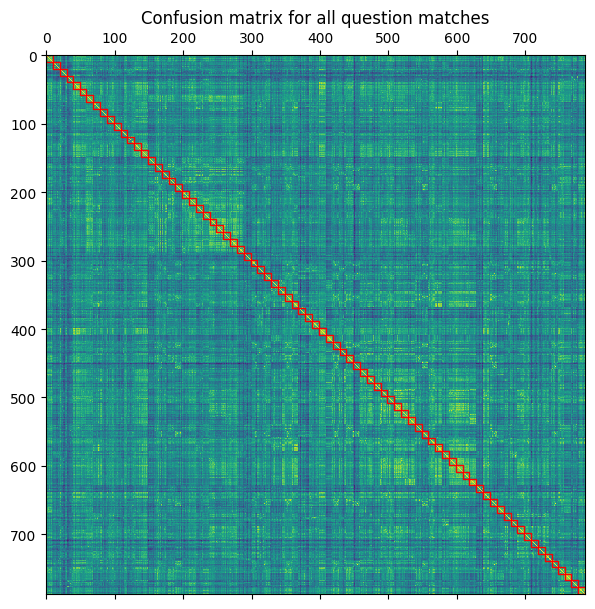

In [233]:
faq.total_confusion()

In [195]:
acc, cm = faq.mean_match_test()
print(f"\nQuestion Mean-Match Accuracy: {acc}")

acc, cm = faq.cross_match_test()
print(f"\nQuestion Cross-Match Accuracy: {acc}")

(79, 300)

Question Mean-Match Accuracy: 0.6890862944162437

Question Cross-Match Accuracy: 0.5215736040609137


In [196]:
# Ambiguous matches
path_to_save = "780_upv_questions/same_question_different_answers.json"
faq.get_same_question_different_answer_pairs(save_path=path_to_save)

{'Jaké jsou možnosti podání přihlášky průmyslového vzoru? ': ['51', '49'],
 'Kdo může podat přihlášku průmyslového vzoru?': ['52', '49'],
 'Kdo může podat přihlášku užitného vzoru?': ['61', '59'],
 'Jak mohu objednat rešeršní služby Úřadu?': ['65', '45'],
 'Jak dlouho trvá zpracování rešerše?': ['65', '45', '74'],
 'Co znamená kvalifikované zveřejnění technického řešení?': ['68', '58']}

In [197]:
faq.get_most_confused_questions(cos_sim_threshold=0.85) # with mean-match

(788, 79)
(788,)
40     Kde najdu právní předpisy týkající se ochrany ...
41     Na jaké stránce jsou uvedeny nejdůležitější pr...
42     Jaké právní předpisy jsou dostupné na stránkác...
399    Kde mohu najít právní předpisy týkající se pop...
400    Jaké jsou nejdůležitější právní předpisy týkaj...
402    Jaké předpisy se týkají poplatků na Úřadu prům...
403    Kde najdu předpisy týkající se poplatků při ří...
407    Jaké právní předpisy upravují poplatky na Úřad...
Name: question, dtype: object


In [7]:
path_to_save = "780_upv_questions/most_missclassified_class_pairs"
faq.get_most_misclassified_class_pairs(n_of_common_misses=3, save_path=path_to_save)

(19, 78) 3
(19, 55) 3
(29, 78) 3
(30, 55) 3
(31, 69) 3
(34, 33) 5
(36, 57) 5
(43, 47) 3
(45, 55) 3
(49, 59) 3
(53, 62) 4
(54, 76) 3
(58, 68) 3
(64, 40) 4
(65, 55) 3
(77, 21) 3
['19:78', '19:55', '29:78', '30:55', '31:69', '34:33', '36:57', '43:47', '45:55', '49:59', '53:62', '54:76', '58:68', '64:40', '65:55', '77:21']


In [254]:
questions_xlsx = "780_upv_questions/expanded_data_all2.xlsx"
# questions_xlsx = "upv_faq/Q50_questions.xlsx"
c = TFIDF_Classifier(questions_xlsx)

[nltk_data] Downloading package wordnet to /home/micha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [276]:
test_data = c.structure_data(test_data_percent=0.1)

c.get_TFIDF_matrix()

[nltk_data] Downloading package wordnet to /home/micha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TFIDF matrix shape: (79, 1161)


In [277]:
c.classify_sentence("Co by nastalo kdyby patent byl zrušen?")

73

In [278]:
c.classify_test_sentences_list(test_data)

Got right: 0.5769230769230769


In [279]:
test_data = c.structure_data(test_data_percent=1) # without removal from train data
c.get_TFIDF_matrix()
c.classify_test_sentences_list(test_data)

TFIDF matrix shape: (79, 1222)
Got right: 0.8261421319796954
